<a href="https://colab.research.google.com/github/iannwtf19/iannwtf19/blob/homework8-autoencoder/Week8/Homework8_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 1. Data Preparation

## Adding noise
Let's define a function that takes an image and applies noise with a given noise factor.
Later we'll use this function to apply it to our datasets via .map() function.

In [2]:
def add_noise(img, noise_factor):
    # create a random tensor and add to the image with a given noise factor
    img = img + tf.random.normal(shape=img.shape) * noise_factor
    # clip values, so we don't go above 1.0
    img = tf.clip_by_value(img, clip_value_min=0., clip_value_max=1.)

    return img


We drop the labels since we don't need them. We also do the regular preparation steps here, like shuffle, batch etc.
Since last layer is sigmoid, we normalize image values to be between 0 and 1.

In [3]:
def prepare_data(ds, batch_size, noise_factor):
    # drop labels, cast & normalize image data to between 0 and 1
    ds = ds.map(lambda img, target: tf.cast(img, tf.float32) / 255.)
    # add noise to images and map to a tuple of (noised, original)
    ds = ds.map(lambda img: (add_noise(img, noise_factor), img))

    return ds.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Define hyperparameters

In [4]:
batch_size = 16
learning_rate = 0.001
noise_factor = 0.2
num_epochs = 10

## Apply noise and preparation steps to MNIST datasets

In [31]:
# Generate train & test datasets
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
noisy_train_ds = prepare_data(train_ds, batch_size, noise_factor)
noisy_test_ds = prepare_data(test_ds, batch_size, noise_factor)

## Visualization before training
We first define a function that we'll use to visualize our data.
The function will allow us to plot _n_ images from multiple datasets.
Each dataset will be displayed on a separate row.

In [32]:
def plot_examples(data_dict, n):
    """
    Plots a given number of images for each dataset in the dictionary.
    It takes `n` examples from each dataset and displays them on separate rows.
    Each row will have n elements from the corresponding dataset.
    :param data_dict: titles and datasets to be plotted.
        should have the type {"title1": dataset1, "title2": dataset2...}
    :param n: number of examples, which corresponds to number of examples from each dataset
    """
    rows = len(data_dict)
    plt.figure()
    for i in range(n):
        for j, (title, data) in enumerate(data_dict.items()):
            ax = plt.subplot(rows, n, (j * n) + i + 1)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.gray()
            plt.title(title)
            plt.imshow(tf.squeeze(data[i]))
    plt.show()

Let's plot 5 noisy images that we generated, with their originals on a separate row

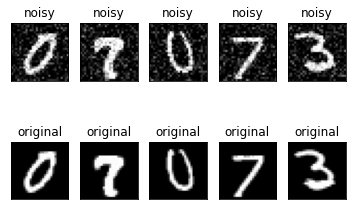

In [33]:
# Show noisy and original examples
for noisy, orig in noisy_train_ds.take(1):
    plot_examples({"noisy": noisy, "original": orig}, n=5)

# Convolutional Encoder
Let's define the encoder model that we will use for our autoencoder.
We'll have 2 convolutional layers that will bring the 28x28x1 MNIST image down to first
14x14, then to 7x7.
Then we use a Flatten layer to turn this into a vector of size 49.
Finally, we have an output layer that will define our embedding, with the given embedding size.

In [34]:
class ConvolutionalEncoder(tf.keras.Model):
    def __init__(self, embedding_size):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                            strides=2, input_shape=(28, 28, 1))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                            strides=2)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(embedding_size)

    def call(self, x, **kwargs):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)

        return x


# Convolutional Decoder
And now we define the decoder model that we'll use as part of our autoencoder.
This decoder will take the embedding vector, increase it to a vector of size 49, which we
reshape again into 7x7.
Then we apply Conv2DTranspose layers to scale it up to first 14x14, then to 28x28.
Finally we have a single Conv2D layer with a single filter and sigmoid activation,
that will output our final image.

In [9]:
class ConvolutionalDecoder(tf.keras.Model):
    def __init__(self, embedding_size):
        super().__init__()
        self.dense = tf.keras.layers.Dense(7 * 7, activation='relu', input_shape=(embedding_size,))
        self.reshape = tf.keras.layers.Reshape(target_shape=(7, 7, 1))

        self.transpose1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2,
                                                          padding='same')
        self.transpose2 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2,
                                                          padding='same')
        self.output_conv = tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation='sigmoid', padding='same')

    def call(self, x, **kwargs):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.transpose1(x)
        x = self.transpose2(x)
        x = self.output_conv(x)

        return x

# Autoencoder model
We define our autoencoder model with a given embedding size, which will create appropriate
encoder and decoder models. The input will be first processed by the encoder and its output
will then be processed by the decoder.

In [10]:
class ConvolutionalAutoencoder(tf.keras.Model):
    def __init__(self, embedding_size):
        super().__init__()

        self.encoder = ConvolutionalEncoder(embedding_size)
        self.decoder = ConvolutionalDecoder(embedding_size)

        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.MeanAbsoluteError(name="MAE")]

    def call(self, x, **kwargs):
        z = self.encoder(x)
        x_prime = self.decoder(z)

        return x_prime

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    def train_step(self, data):
        sequence, label = data
        with tf.GradientTape() as tape:
            output = self(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        sequence, label = data
        output = self(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)

        return {m.name: m.result() for m in self.metrics}

# Training
Let's define our embedding size, create an autoencoder instance and start training.

In [13]:
embedding_size = 10

autoencoder = ConvolutionalAutoencoder(embedding_size)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.MeanSquaredError())
history = autoencoder.fit(noisy_train_ds, validation_data=noisy_test_ds, epochs=num_epochs)

Epoch 1/10
3750/3750 [==============================] - 38s 7ms/step - loss: 0.0477 - MAE: 0.1090 - val_loss: 0.0365 - val_MAE: 0.0888
Epoch 2/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0354 - MAE: 0.0843 - val_loss: 0.0335 - val_MAE: 0.0801
Epoch 3/10
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0332 - MAE: 0.0798 - val_loss: 0.0321 - val_MAE: 0.0789
Epoch 4/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0319 - MAE: 0.0772 - val_loss: 0.0313 - val_MAE: 0.0766
Epoch 5/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0312 - MAE: 0.0756 - val_loss: 0.0308 - val_MAE: 0.0762
Epoch 6/10
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0306 - MAE: 0.0746 - val_loss: 0.0300 - val_MAE: 0.0746
Epoch 7/10
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0302 - MAE: 0.0737 - val_loss: 0.0298 - val_MAE: 0.0715
Epoch 8/10
3750/3750 [==============================] -

# Visualization
Let's plot our training and validation losses as usual

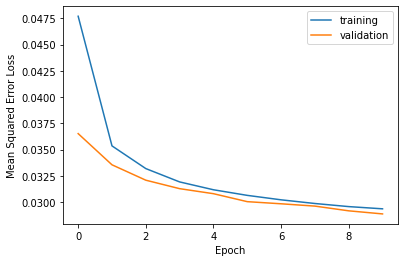

In [14]:
# Plot training and validation losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels=["training", "validation"])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.show()

## Plotting noised, original and denoised images
Here we use our function from before to plot the images. Now we also show the output of our
autoencoder, which will be the denoised versions.

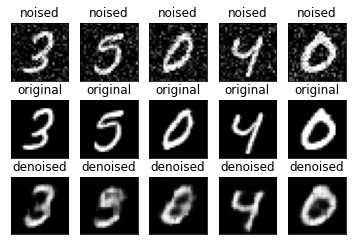

In [15]:
# Denoise some new examples from test dataset, display alongside noised & original versions for comparison
for noisy, orig in noisy_test_ds.take(1):
    decoded = autoencoder(noisy, training=False)
    plot_examples({"noised": noisy, "original": orig, "denoised": decoded}, n=5)

In [11]:
# Optional - mount Google Drive when running from Colab so we can save our model and logs to Drive
from google.colab import drive

drive.mount('/gdrive')

Mounted at /gdrive


In [16]:
# Save the complete model
autoencoder.save("saved_autoencoder")

# Latent space analysis
We will embed the first 1000 images of the test set using the encoder. Then we reduce the dimensionality of the embeddings to two using the t-SNE algorithm. Then we plot the data points, coloured according to their class.
## Data preparation
For this, we first prepare a separate batch of data. Our batch size will be 1000. This time we also need the labels, since our scatter plot will be colored based on the labels. So we first define a data preparation function similar to the one in the beginning, but for the sample dataset that we will use in the analysis.

In [17]:
def prepare_data_for_analysis(ds, batch_size, noise_factor):
    # cast & normalize image data to between 0 and 1
    ds = ds.map(lambda img, target: (tf.cast(img, tf.float32) / 255., target))
    # add noise to images and map to a tuple of (noised_image, label)
    ds = ds.map(lambda img, target: (add_noise(img, noise_factor), target))

    return ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Encoding sample images
Now let's use our encoder model to create embeddings from the sample images. This will reduce the 28x28 images to vectors of size 10.

1/1 [==============================] - 0s 215ms/step


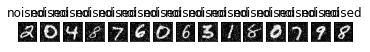

In [35]:
sample_ds = prepare_data_for_analysis(test_ds, 1000, 0.2).take(1)
sample_images = sample_ds.map(lambda imgs, labels: imgs)
sample_labels = sample_ds.map(lambda imgs, labels: labels)
encoded_samples = autoencoder.encoder.predict(sample_images)
for images, labels in sample_ds:
  plot_examples({"noised": images}, n=15)

## Dimensionality reduction via t_SNE
Now we need to reduce the dimensionality of image representations from 10 (embedding_size) to 2. For this, we will use sklearn.manifold.TSNE library.

Here we have another hyperparameter: perplexity. Recommended values are between 5 and 50. We will set it to 30.

In [40]:
from sklearn.manifold import TSNE


perplexity = 30
tsne_results = TSNE(n_components=2, learning_rate='auto',
                     init='random', perplexity=perplexity).fit_transform(encoded_samples)

## Plotting the latent space

[Text(0.5, 1.0, 'MNIST data T-SNE projection')]

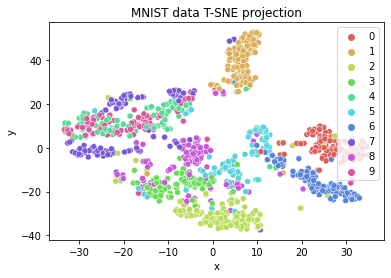

In [41]:
import numpy as np
import seaborn as sns
import pandas as pd 


# Convert dataset of labels to numpy array of integers
labels = np.concatenate(list(sample_labels))

# Set first axis to "x" & second axis to "y" in a dataframe
df = pd.DataFrame({"x": tsne_results[:,0], "y": tsne_results[:,1]})

# Plot results, coloring by labels
sns.scatterplot(x=df["x"], y=df["y"], hue=labels,
                palette=sns.color_palette("hls", 10)).set(title="MNIST data T-SNE projection")

## Evaluating the plot
Here we see that our autoencoder clearly differentiated at least some of the numbers. Some numbers like 0, 1, 6 form clearly separate clusters with only a few datapoints from other classes. 0 and 6 are close to each other, while 1 is quite far away from them.

Number 3 also has its own cluster, but its clouded with samples from number 8 and 5. This is interesting, but not totally unexpected. Many hand-written examples of 3 and 8 may look similar, especially when noise is introduced. Some cases of 5 may also look like an incomplete 8.

Numbers 4 and 9 are almost together in one big cluster that spans a wide range. We already noticed this when we plotted our denoised images with the originals: Quite often an input of 4 can result in a 9.


# Linear Interpolation
As discussed above, numbers 4 and 9 can look similar. Let's linearly interpolate between these two numbers and generate a decoded output at each step. Hopefullly we will see the transition from one to the other!

1/1 [==============================] - 0s 20ms/step


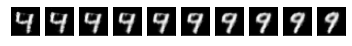

In [48]:
encoded_list = list(encoded_samples)
first = encoded_list[2]
second = encoded_list[13]
steps = np.linspace(first, second, num=10)
decoded_steps = autoencoder.decoder.predict(steps)
plot_examples({"": decoded_steps}, n=10)